# <font color='yellow'> Set-up: MOF </font> 

In [10]:
import sys

sys.path.append("../")

import warnings
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from utils import hparam_tunning

from sklearn.exceptions import FitFailedWarning
from sklearn.model_selection import train_test_split

from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

sns.set(style="darkgrid", rc = {"figure.figsize": (10, 10)})

SEED = 1234
np.random.seed(SEED)

data_path = Path("./data/mof/")

surv_data = pd.read_csv(data_path / "surv_data_MOF.csv", index_col="studyid")
X = surv_data.drop(columns=["status", "time"])
y = Surv.from_dataframe(event = "status", time = "time", data = surv_data_mof)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# <font color='yellow'> 1. COX-PH </font> 

In [85]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train) 

CoxPHSurvivalAnalysis()

In [74]:
print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

C-Index score 
 train: 0.7292689913274084 
 test: 0.6613489455908335


<AxesSubplot:>

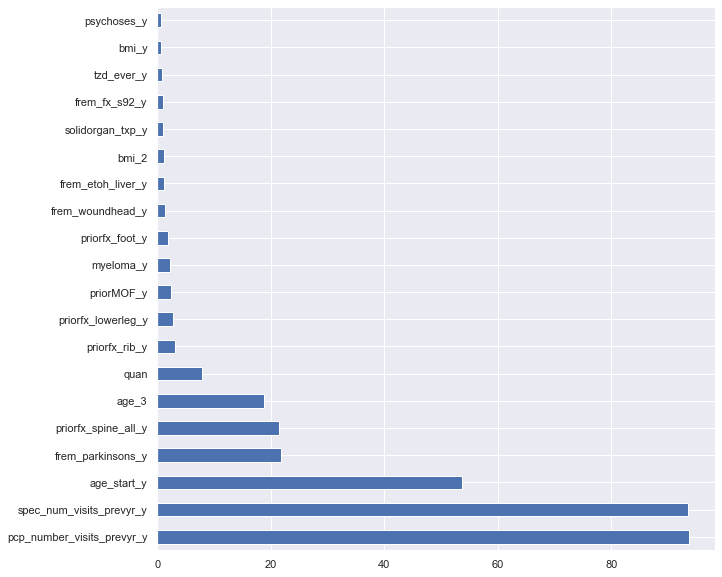

In [68]:
hazard_ratio = pd.Series(estimator.coef_, index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 2. COX-PH Ridge </font> 

In [ ]:
alphas = 10. ** np.linspace(-4, 4, 50)
kf = KFold(n_splits = 5, shuffle = True)    
scores = {'alpha': [], 
           'score': [], 
           'std': []}

for alpha in tqdm(alphas, desc = "alpha tunning: "):
    estimator = CoxPHSurvivalAnalysis(alpha = alpha)
    cv_res = cross_validate(estimator, X_train, y_train, cv = kf, error_score=0.5, n_jobs=-1)
    scores['alpha'].append(round(alpha, 5))
    scores['score'].append(np.mean(cv_res['test_score']))
    scores['std'].append(np.std(cv_res['test_score']))
    
scores = pd.DataFrame.from_dict(scores)

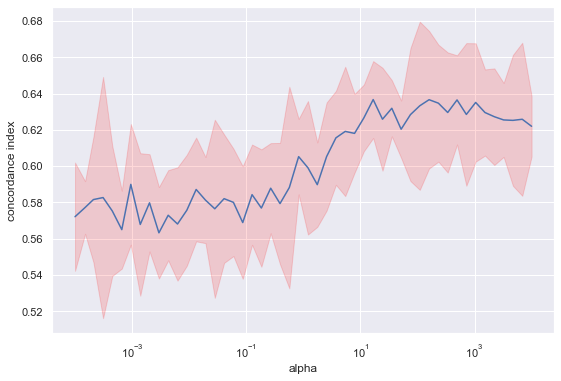

In [140]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(scores['alpha'],scores['score'])
ax.fill_between(scores['alpha'], scores['score'] - scores['std'], scores['score'] + scores['std'], alpha=0.15, color = "red")
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.grid(True)

C-Index score 
 train: 0.7038471066236134 
 test: 0.6875690869952631


<AxesSubplot:>

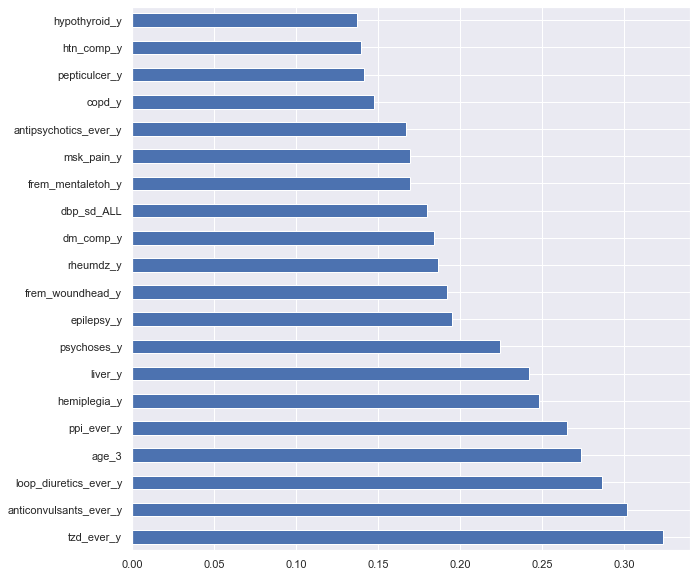

In [143]:
estimator = CoxPHSurvivalAnalysis(alpha = scores.alpha[np.argmax(scores.score)])
estimator.fit(X_train, y_train)

print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

hazard_ratio = pd.Series(estimator.coef_, index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 3. COX-PH Lasso </font> 

In [153]:
alphas = 10. ** np.linspace(-4, 1, 50)
kf = KFold(n_splits = 5, shuffle = True)    
scores = {'alpha': [], 
           'score': [], 
           'std': []}

for alpha in tqdm(alphas, desc = "alpha tunning: "):
    estimator = CoxnetSurvivalAnalysis(alphas = [alpha], l1_ratio=1)
    cv_res = cross_validate(estimator, X_train, y_train, cv = kf, error_score=0.5, n_jobs=-1)
    scores['alpha'].append(round(alpha, 5))
    scores['score'].append(np.mean(cv_res['test_score']))
    scores['std'].append(np.std(cv_res['test_score']))
    
scores = pd.DataFrame.from_dict(scores)

alpha tunning:  46%|████▌     | 23/50 [00:14<00:07,  3.70it/s]/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
alpha tunning:  48%|████▊     | 24/50 [00:15<00:07,  3.64it/s]/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **

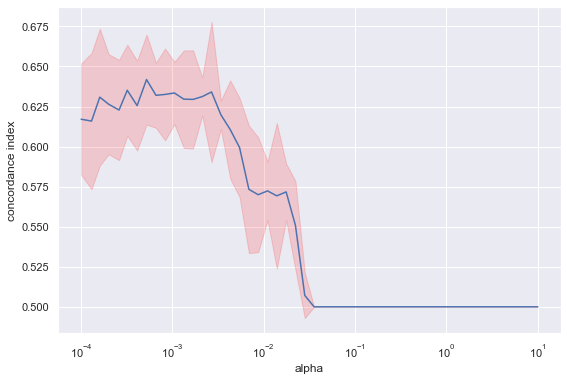

In [154]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(scores['alpha'],scores['score'])
ax.fill_between(scores['alpha'], scores['score'] - scores['std'], scores['score'] + scores['std'], alpha=0.15, color = "red")
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.grid(True)

C-Index score 
 train: 0.6870996337783121 
 test: 0.6834874043499163


<AxesSubplot:>

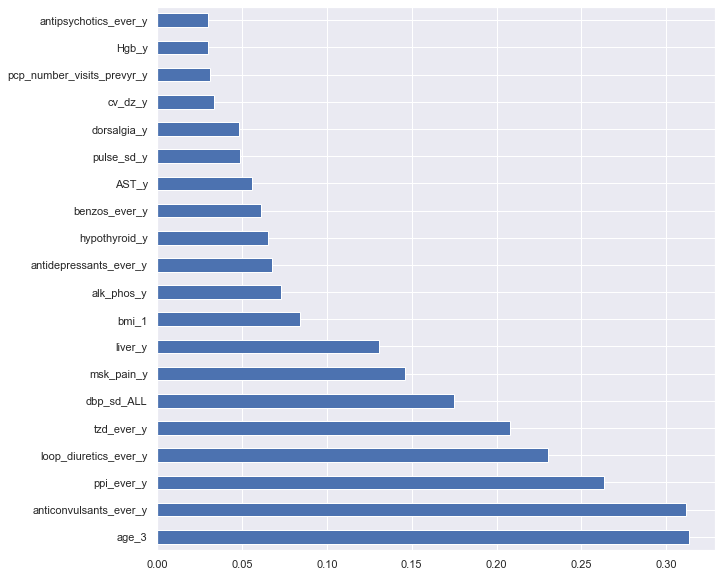

In [159]:
estimator = CoxnetSurvivalAnalysis(alphas = [scores.alpha[np.argmax(scores.score)]])
estimator.fit(X_train, y_train)

print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

hazard_ratio = pd.Series(estimator.coef_[:, 0], index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 4. COX-PH ElasticNet </font> 

In [162]:
ratios = np.linspace(0.1, 0.9, 10)
alphas = 10. ** np.linspace(-4, 4, 50)
scores = np.zeros((10, 50))

kf = KFold(n_splits = 5, shuffle = True)    

for i, ratio in enumerate(ratios):
    for j, alpha in enumerate(alphas):
        estimator = CoxnetSurvivalAnalysis(alphas = [alpha], l1_ratio = ratio)
        cv_res = cross_validate(estimator, X_train, y_train, cv = kf, error_score=0.5, n_jobs=-1)
        scores[i, j] = np.mean(cv_res['test_score'])

/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/Fracture/lib/python3.8/site-pac

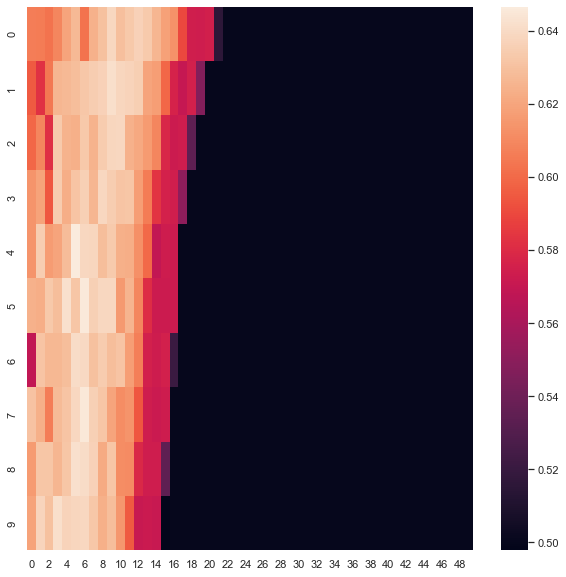

In [163]:
ax = sns.heatmap(scores)

C-Index score 
 train: 0.6845467884570419 
 test: 0.6823483301233079


<AxesSubplot:>

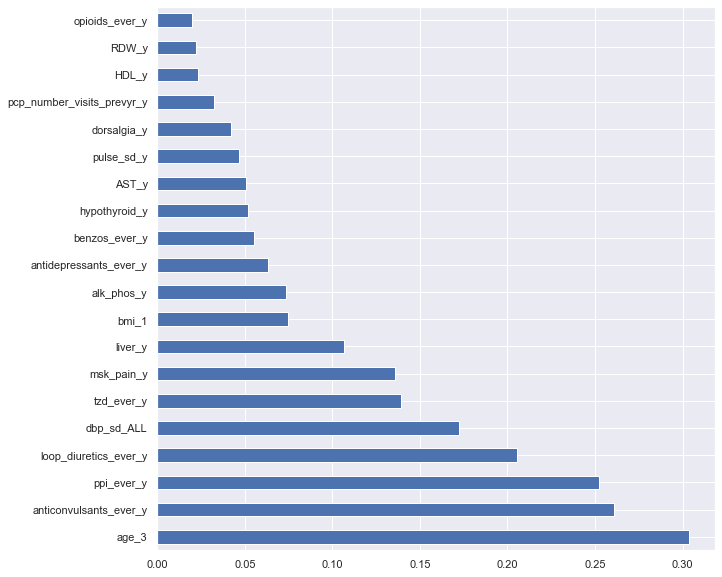

In [171]:
ind = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
estimator = CoxnetSurvivalAnalysis(alphas = [alphas[ind[1]]], l1_ratio = ratios[ind[0]])

estimator.fit(X_train, y_train)

print(f"C-Index score \n train: {estimator.score(X_train, y_train)} \n test: {estimator.score(X_test, y_test)}")

hazard_ratio = pd.Series(estimator.coef_[:, 0], index=X_train.columns)
hazard_ratio.sort_values(ascending=False, inplace=True)
hazard_ratio[:20].plot.barh()

# <font color='yellow'> 5. Random Surv Forest </font> 

In [8]:
rsf = RandomSurvivalForest(verbose = 0, n_jobs = -1, max_features=None, n_estimators=100, max_depth=8)
rsf.fit(X_train, y_train)
        
train_score = rsf.score(X_train, y_train)
test_score = rsf.score(X_test, y_test)

print(f"train score = {train_score:.5f}; test score = {test_score:.5f}")

train score = 0.79137; test score = 0.62940


# <font color='yellow'> 7. Component Wide Gradient Boosting </font> 

In [2]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

estimator = ComponentwiseGradientBoostingSurvivalAnalysis(loss="coxph")
estimator.fit(X_train, y_train)

ComponentwiseGradientBoostingSurvivalAnalysis()

In [3]:
train_score = estimator.score(X_train, y_train)
test_score = estimator.score(X_test, y_test)

print(f"train score = {train_score:.5f}; test score = {test_score:.5f}")

train score = 0.58690; test score = 0.59813


# <font color='yellow'> 8. Gradient Boosting </font> 

## <font color='yellow'> 8.1 Drop Out </font> 

dropout_rate tunning: 100%|██████████| 10/10 [40:33<00:00, 243.40s/it]


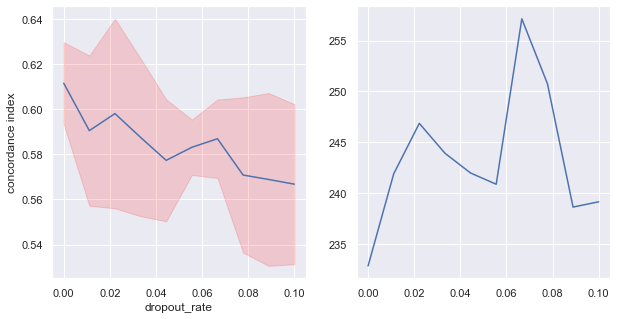

In [80]:
fixed_params = {"loss": "coxph", "n_estimators": 90, "learning_rate": 0.6, "max_depth": 5}
dropout_rate = np.linspace(0., 0.1, 10)
scores = hparam_tunning(dropout_rate, fixed_params, "dropout_rate")

In [77]:
fixed_params['dropout_rate'] = scores.dropout_rate[np.argmax(scores.score)]
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)

print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

 0.69379;  0.60849


## <font color='yellow'> 8.2 Subsample </font> 

subsample tunning: 100%|██████████| 20/20 [13:08:42<00:00, 2366.14s/it]


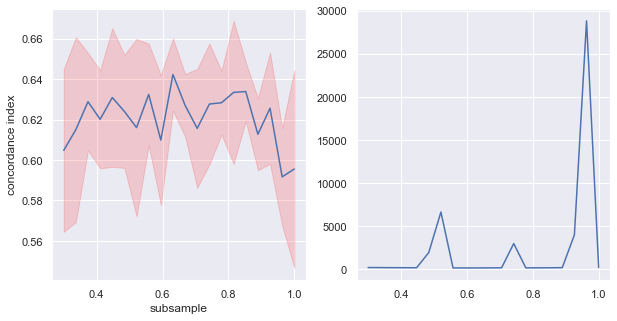

In [81]:
fixed_params = {"loss": "coxph", "n_estimators": 90, "learning_rate": 0.1, "max_depth": 5}

subsample = np.linspace(0.5, 1, 10)
scores = hparam_tunning(subsample, fixed_params, "subsample")

In [82]:

fixed_params['subsample'] = scores.subsample[np.argmax(scores.score)]
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)

print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

 0.89483;  0.65737


## <font color='yellow'> Best </font> 

In [3]:
fixed_params = {"loss": "coxph", "n_estimators": 90, "learning_rate": 0.6, "max_depth": 5}
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)

print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

 0.87936;  0.69516


learning_rate tunning: 100%|██████████| 10/10 [1:01:01<00:00, 366.13s/it]


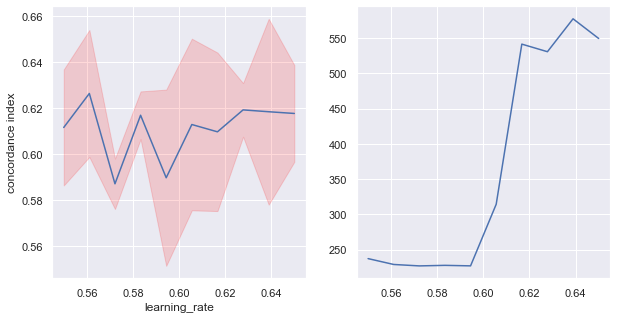

In [4]:
learning_rate = np.linspace(0.55, 0.65, 10)
scores = hparam_tunning(learning_rate, fixed_params, "learning_rate")

In [7]:
fixed_params['learning_rate'] = scores.learning_rate[np.argmax(scores.score)]
estimator = GradientBoostingSurvivalAnalysis(**fixed_params).fit(X_train, y_train)

print(f"{estimator.score(X_train, y_train): .5f}; {estimator.score(X_test, y_test): .5f}")

 0.86647;  0.69395
